In [1]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint

from sheet_id.models.FCN import FCN
from sheet_id.utils.loss_functions import softmax_sparse_crossentropy_ignoring_background, softmax_sparse_crossentropy
from sheet_id.utils.metrics import sparse_accuracy_ignoring_background, sparse_accuracy
from sheet_id.utils.dataPreprocessing import splitTrainValidation
from sheet_id.utils.dataGenerator import DataGenerator
from sheet_id.utils.dwd_utils import generateGroundTruthMaps

import matplotlib.pyplot as plt
import numpy as np

/home/mirlab/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Training

In [2]:
model = FCN(input_shape=(500,500,1), n_classes=124)

In [3]:
loss_fn = softmax_sparse_crossentropy
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-8, decay=0.0, amsgrad=False)
metrics = [sparse_accuracy]
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

In [4]:
callbacks = []

In [5]:
train_partition, validation_partition = splitTrainValidation('../data/', max_size=200, test_size=20, npy_only=True)

In [6]:
params = {'dim': (500,500),
          'batch_size': 1,
          'n_classes': 124,
          'n_channels': 1,
          'shuffle': True,
          'crop': True,
          'crop_size': (500,500),
          'load_npy': True}
training_generator = DataGenerator(train_partition, **params)
validation_generator = DataGenerator(validation_partition, **params)

In [7]:
# history = model.fit_generator(generator=training_generator, epochs=10,
#                               validation_data=validation_generator,
#                               use_multiprocessing=True, workers=10,
#                               callbacks=callbacks,
#                               steps_per_epoch=10)

In [8]:
# model.save_weights('../checkpoints/working_fcn.h5')

In [9]:
# model.load_weights('../checkpoints/working_fcn.h5')

# Visualization

In [10]:
# example_img, energy_map, class_map, bbox_map = training_generator[0]

In [11]:
# model.evaluate(example_img, example_annotation)

In [12]:
# prediction = model.predict(example_img)
# prediction = np.argmax(prediction, axis=-1)
# prediction.shape

In [13]:
# img_id = 12
# plt.figure(figsize=(20,20))
# plt.subplot(1,3,1)
# plt.imshow(example_img[img_id,:,:,0], cmap='gray')
# plt.subplot(1,3,2)
# plt.imshow(example_annotation[img_id,:,:,0], cmap='gray', vmin=0, vmax=125)
# plt.title(np.unique(example_annotation[img_id,:,:,0]))
# plt.subplot(1,3,3)
# plt.imshow(prediction[img_id,:,:], cmap='gray', vmin=0, vmax=125)
# plt.title(np.unique(prediction))
# plt.show()

In [14]:
# mask = 29
# masked = np.zeros_like(prediction[img_id, :, :])
# for row in range(prediction.shape[1]):
#     for col in range(prediction.shape[2]):
#         if prediction[img_id, row, col] == mask:
#             masked[row, col] = 255
#         else:
#             masked[row, col] = 0

# plt.imshow(masked, cmap='gray')
# plt.title('Prediction only for class {:}'.format(mask))
# plt.show()

# Deep Watershed

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers.convolutional import Conv2D
from keras.layers import Input
from keras.models import Model


# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [16]:
n_bins = 10
n_classes = 124

In [17]:
input_map = Input(shape=(500,500,1))
output_featuremaps = model(input_map)
energy_output = Conv2D(n_bins,    (1,1), activation='relu', padding='same', name='energy_map')(output_featuremaps)
class_output  = Conv2D(n_classes, (1,1), activation='relu', padding='same', name='class_map')(output_featuremaps)
bbox_output   = Conv2D(2,         (1,1), activation='relu', padding='same', name='bbox_map')(output_featuremaps)

In [18]:
dwd_model = Model(inputs=[input_map], outputs=[energy_output, class_output, bbox_output])
loss_fn = softmax_sparse_crossentropy
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-8, decay=0.0, amsgrad=False)
metrics = []
dwd_model.compile(loss={
                            "energy_map": loss_fn,
                            "class_map": loss_fn,
                            "bbox_map": "mse",
                        }, 
                  loss_weights={'energy_map': 1.0, 'class_map': 1.0, 'bbox_map': 0.7},
                  optimizer=optimizer, metrics=metrics)

In [ ]:
dwd_model.fit_generator(generator=training_generator, epochs=5000,
                              validation_data=validation_generator,
                              use_multiprocessing=True, workers=10,
                              callbacks=callbacks,
                              steps_per_epoch=10)

Epoch 1/5000
10/10 [==============================] - 9s 884ms/step - loss: 1.7203 - energy_map_loss: 0.0203 - class_map_loss: 0.0083 - bbox_map_loss: 2.4168 - val_loss: 6.4008 - val_energy_map_loss: 0.0218 - val_class_map_loss: 0.0084 - val_bbox_map_loss: 9.1009
Epoch 2/5000
10/10 [==============================] - 6s 618ms/step - loss: 81.2163 - energy_map_loss: 0.0347 - class_map_loss: 0.0126 - bbox_map_loss: 115.9557 - val_loss: 1.9939 - val_energy_map_loss: 0.0309 - val_class_map_loss: 0.0111 - val_bbox_map_loss: 2.7884
Epoch 3/5000
10/10 [==============================] - 6s 614ms/step - loss: 4.7017 - energy_map_loss: 0.0396 - class_map_loss: 0.0206 - bbox_map_loss: 6.6308 - val_loss: 3.1793 - val_energy_map_loss: 0.0270 - val_class_map_loss: 0.0117 - val_bbox_map_loss: 4.4865
Epoch 4/5000
10/10 [==============================] - 6s 620ms/step - loss: 3.1226 - energy_map_loss: 0.0346 - class_map_loss: 0.0131 - bbox_map_loss: 4.3927 - val_loss: 1.8580 - val_energy_map_loss: 0.022

In [202]:
# dwd_model.save_weights('../checkpoints/dwd.h5')

In [25]:
# dwd_model.load_weights('../checkpoints/dwd.h5')

In [113]:
from sheet_id.utils.dwd_utils import find_connected_comp

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from sheet_id.utils.eval_utils import evaluate, filterBoxes

In [172]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

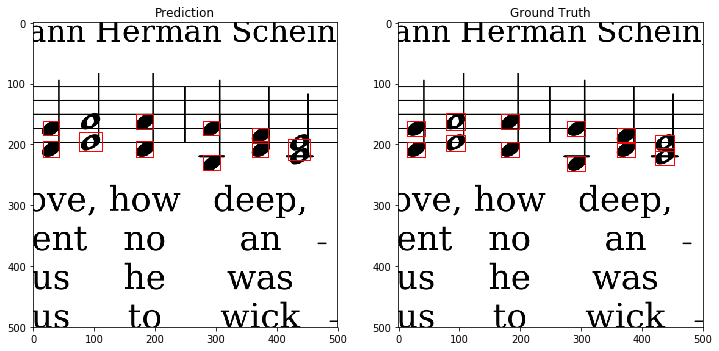

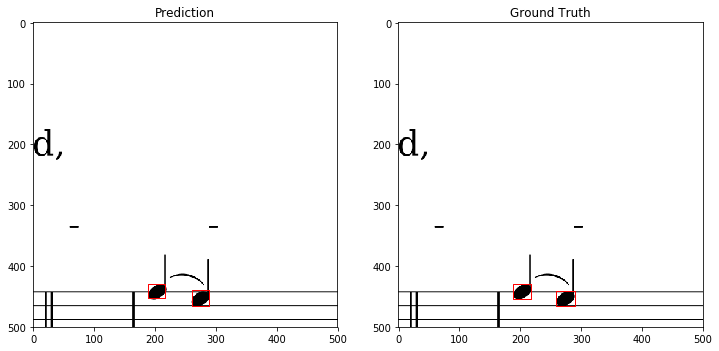

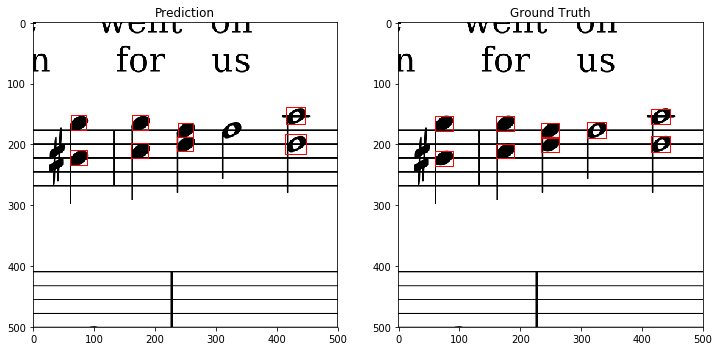

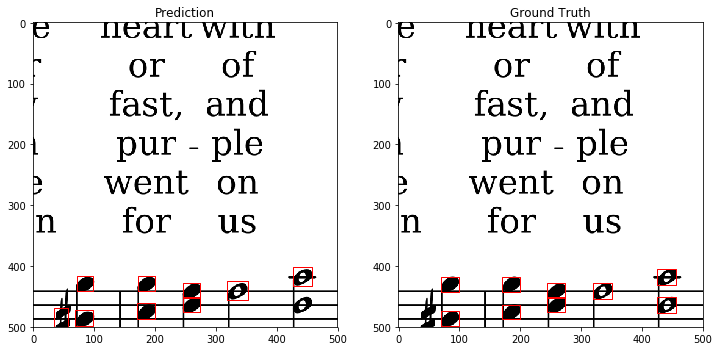

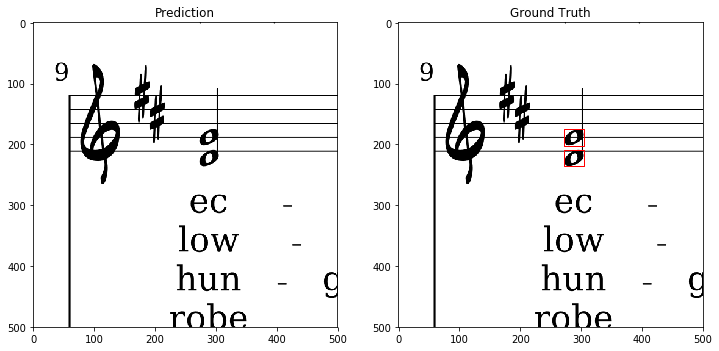

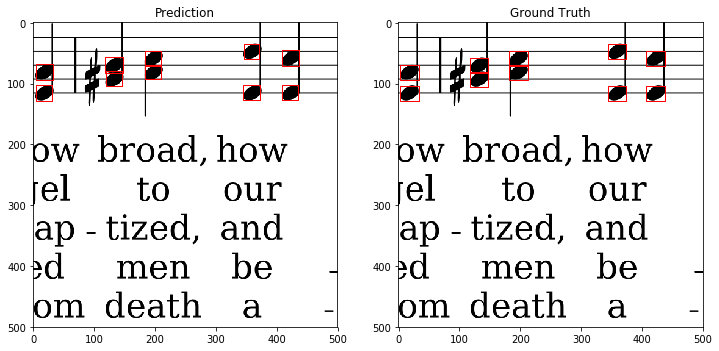

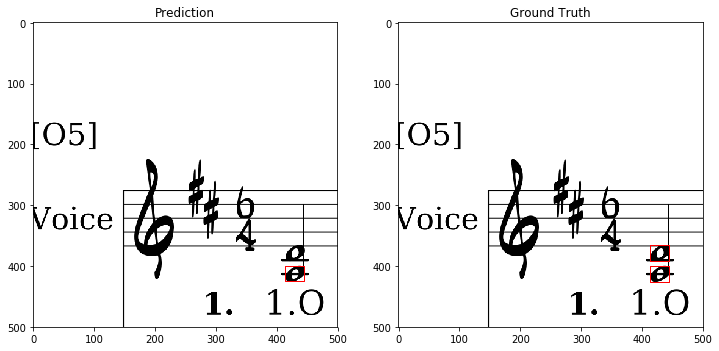

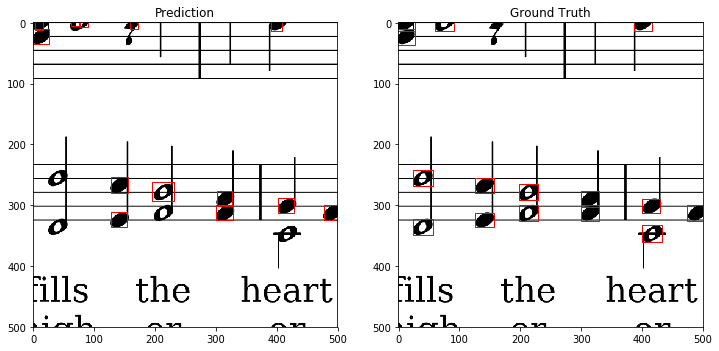

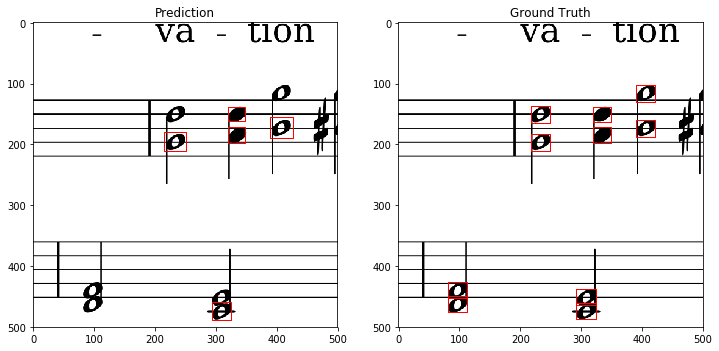

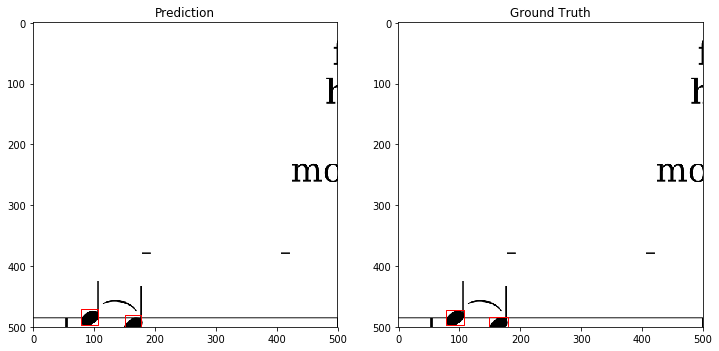

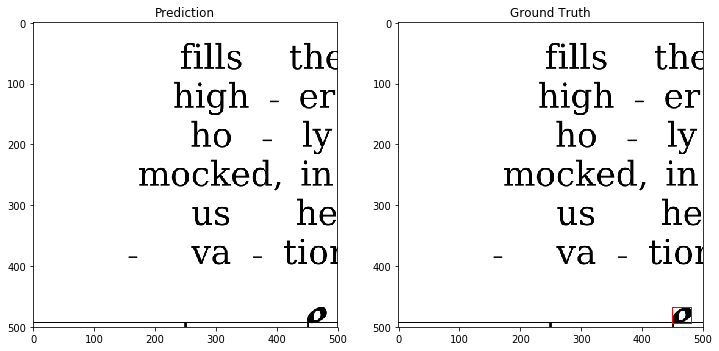

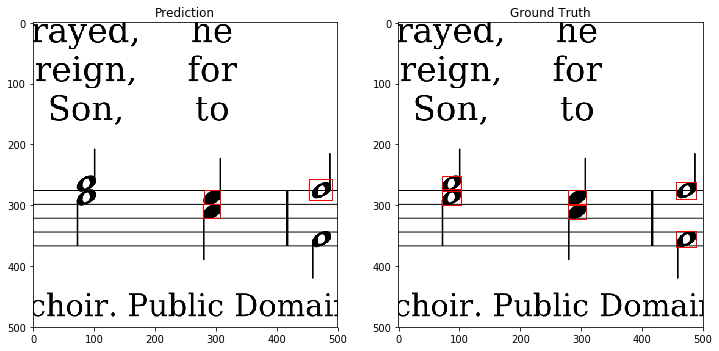

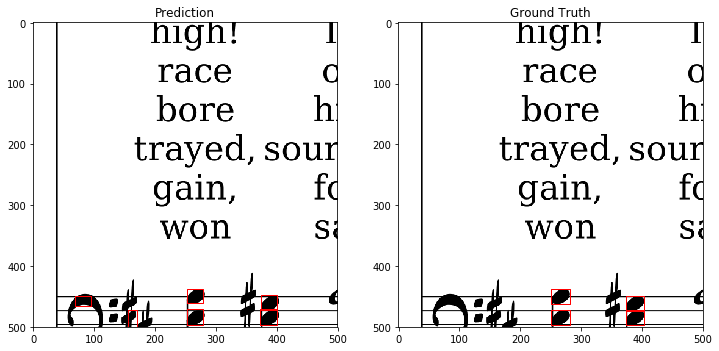

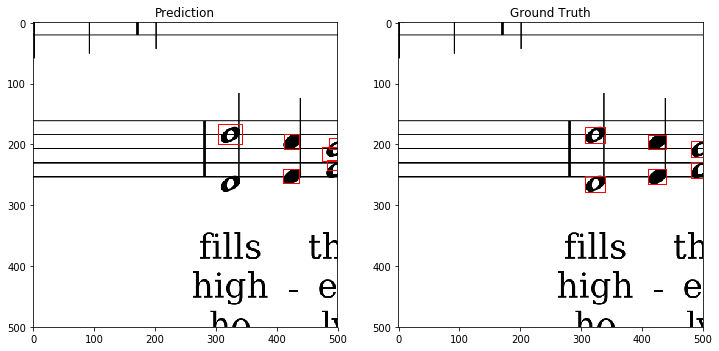

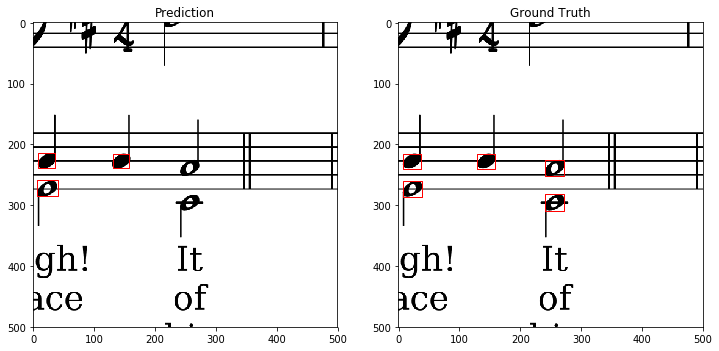

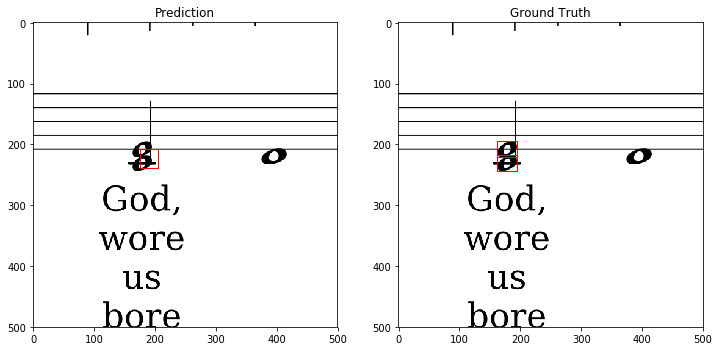

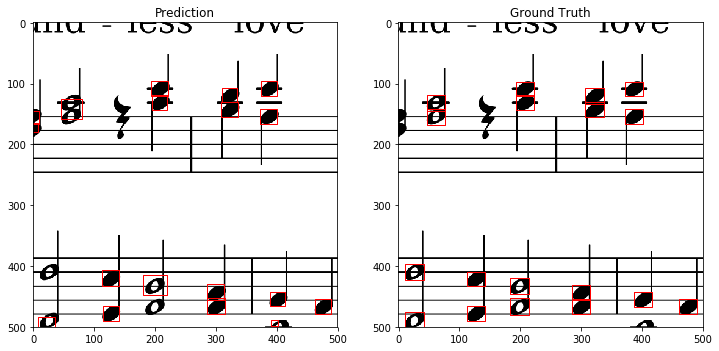

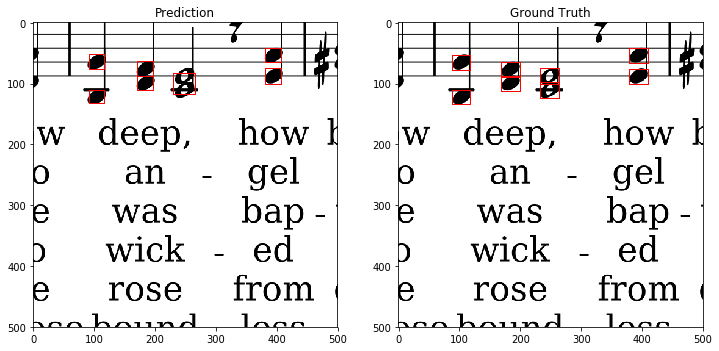

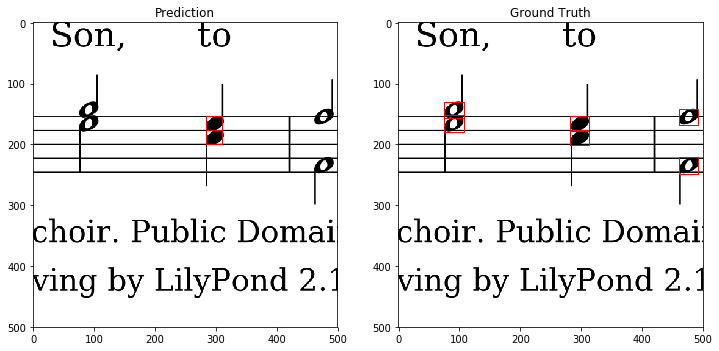

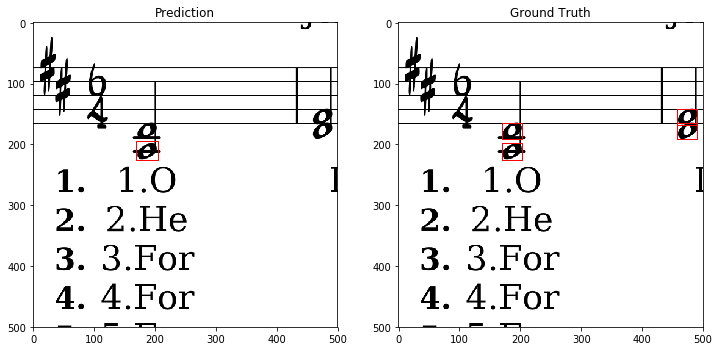

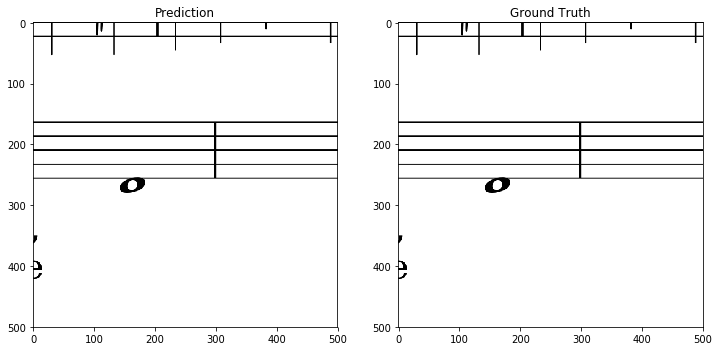

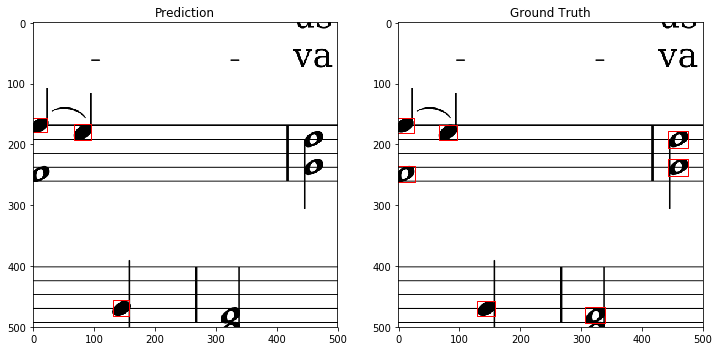

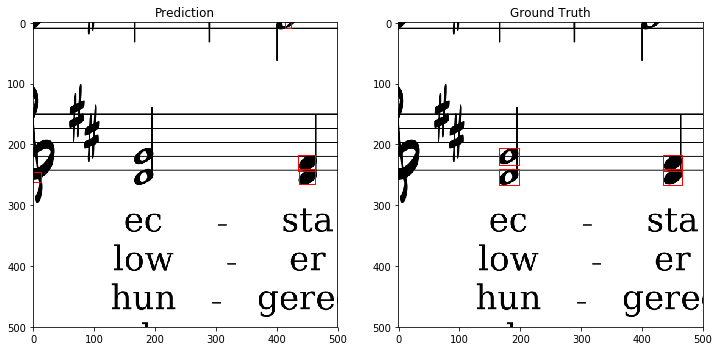

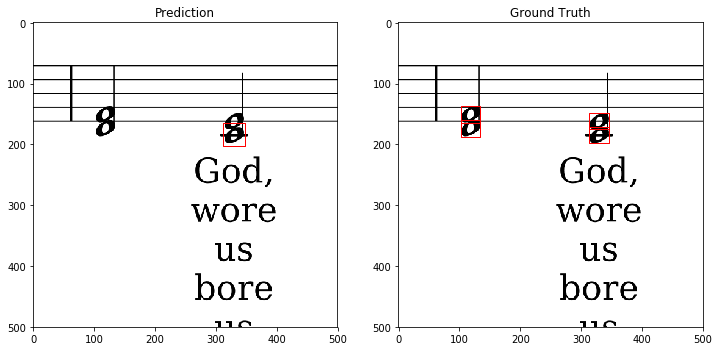

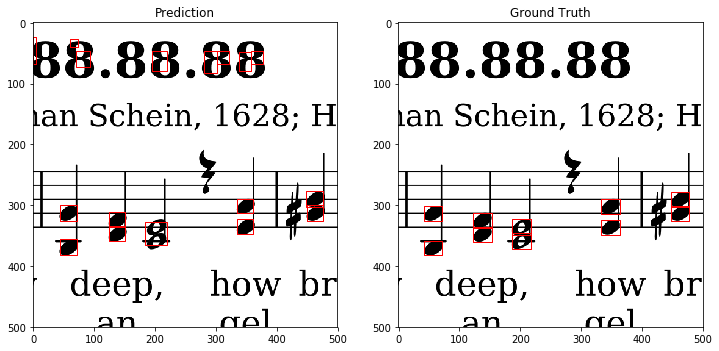

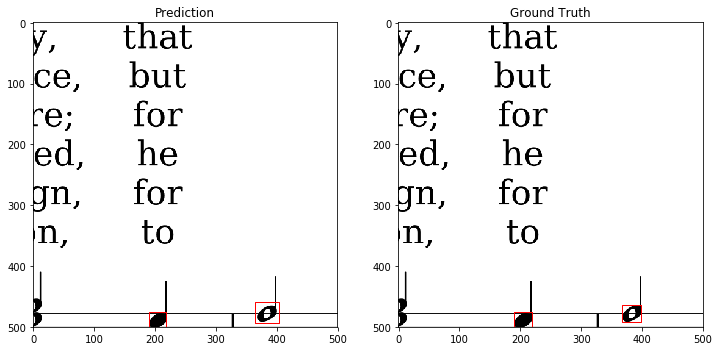

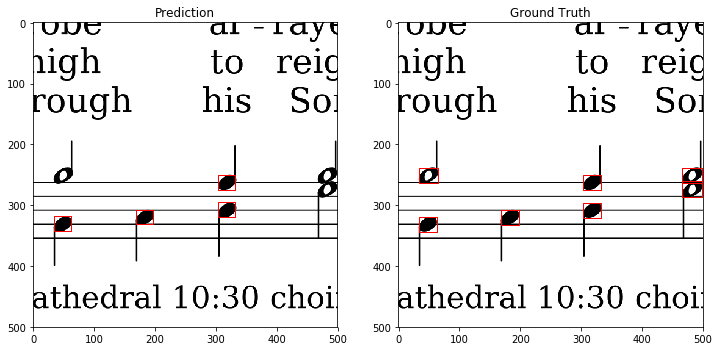

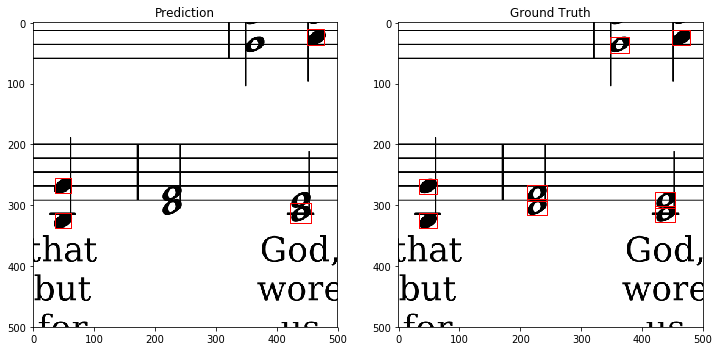

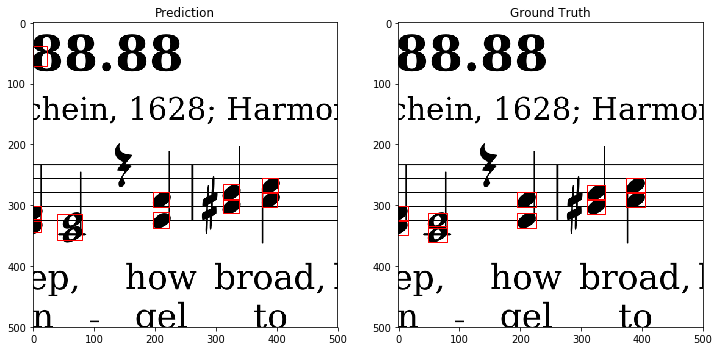

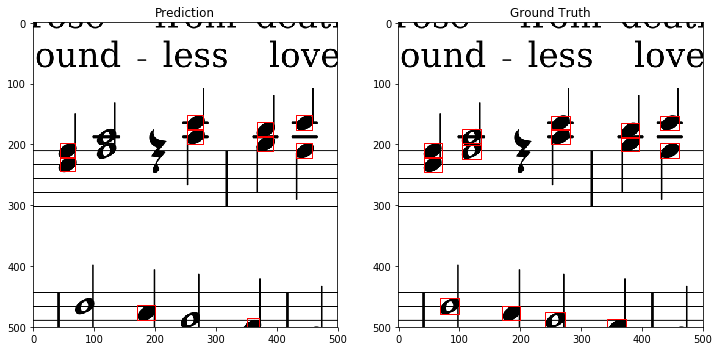

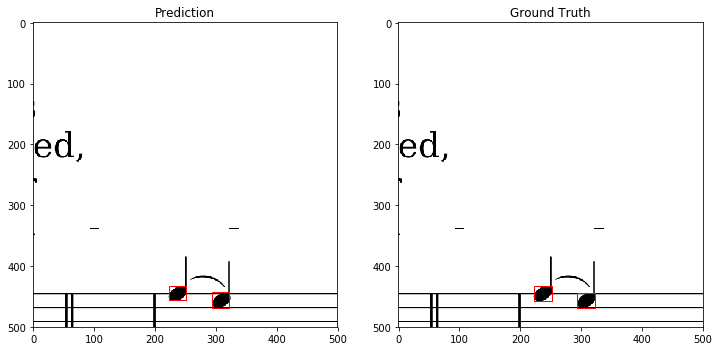

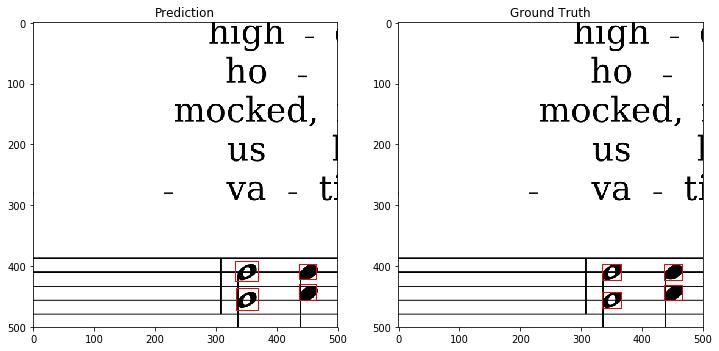

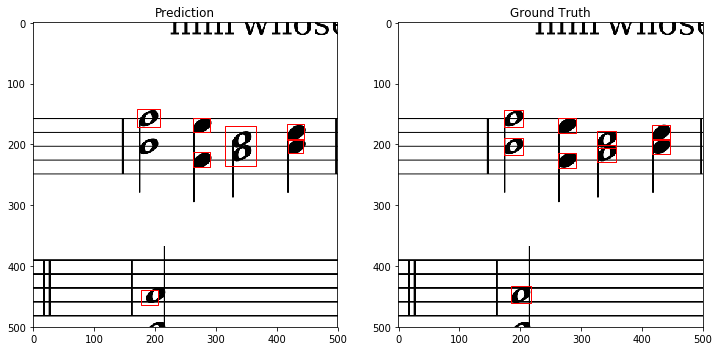

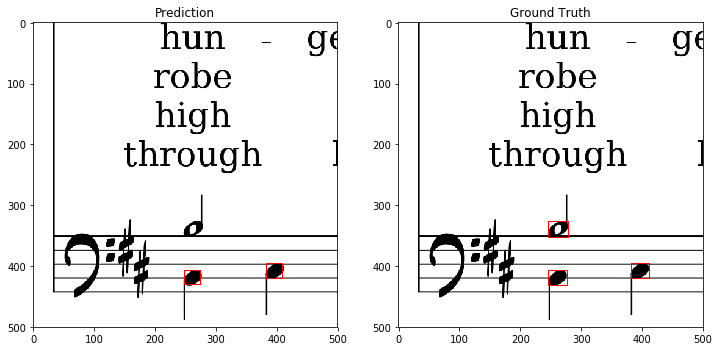

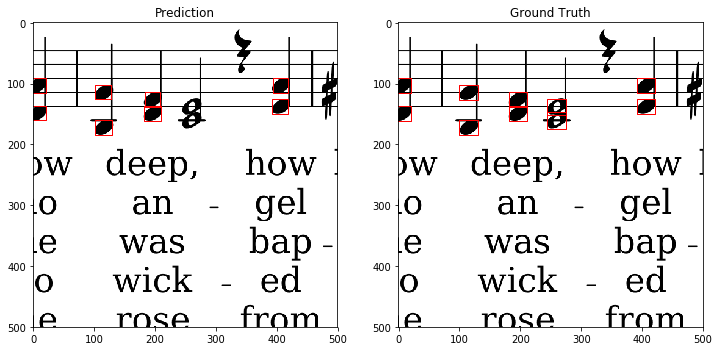

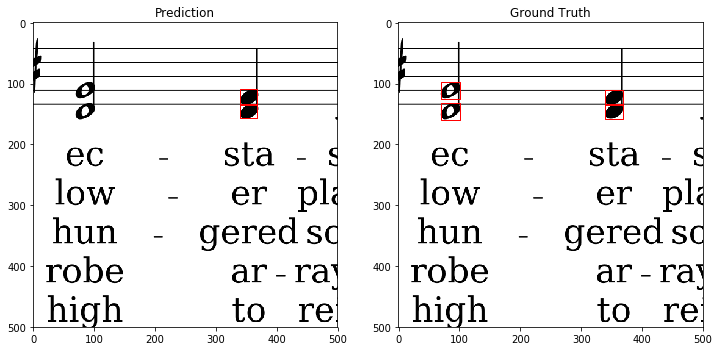

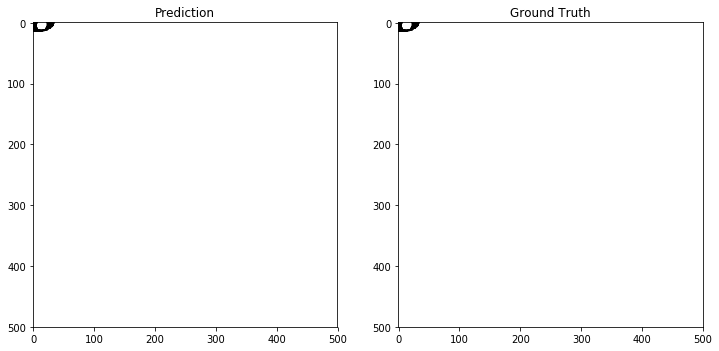

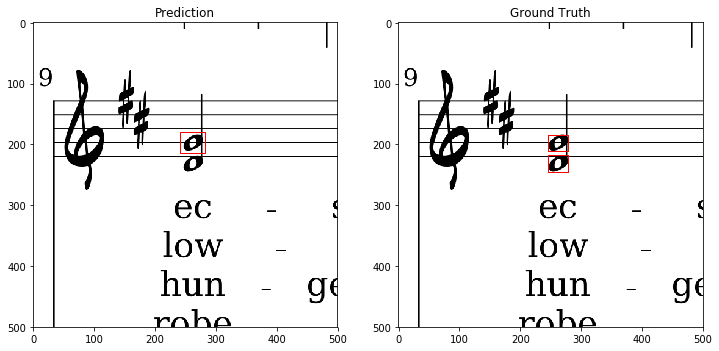

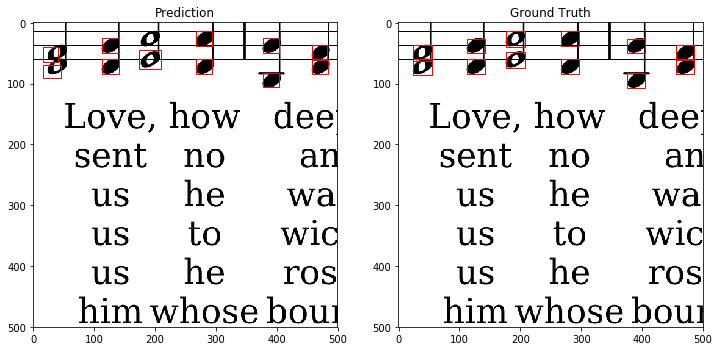

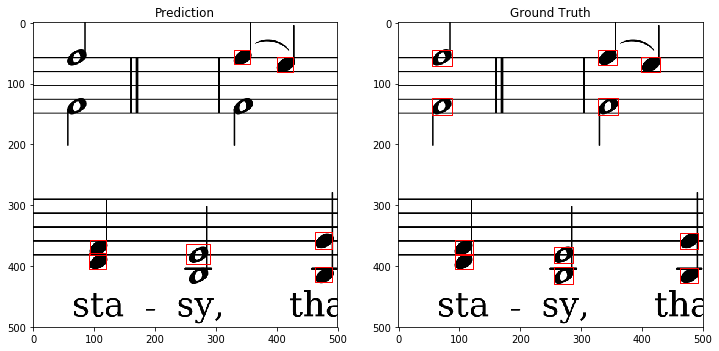

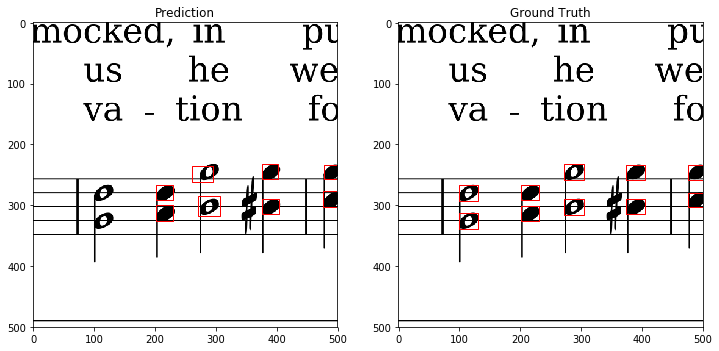

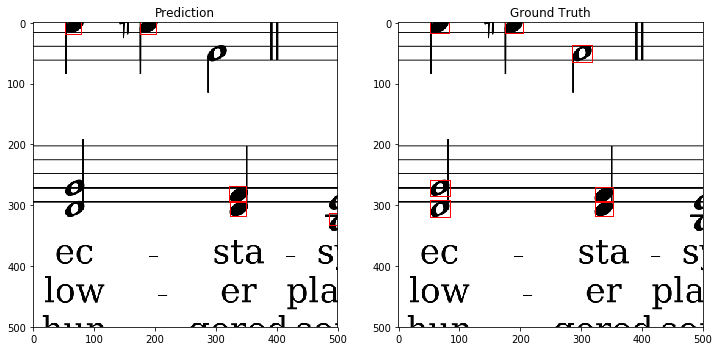

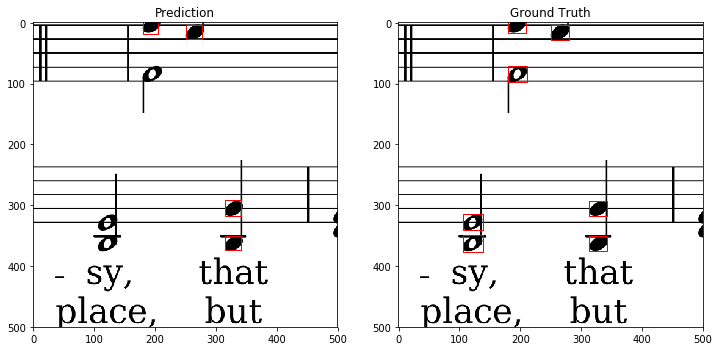

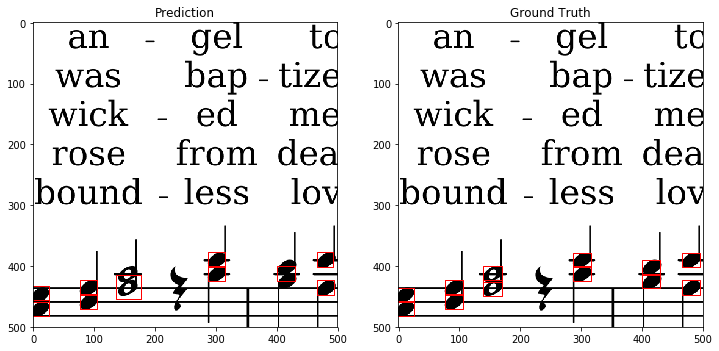

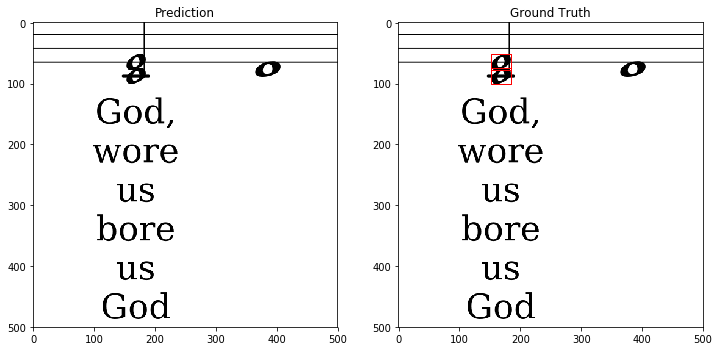

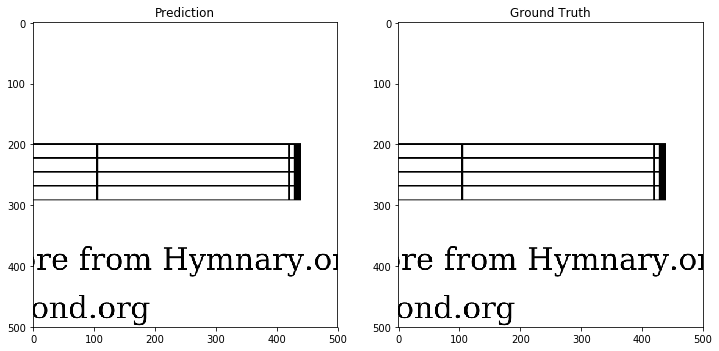

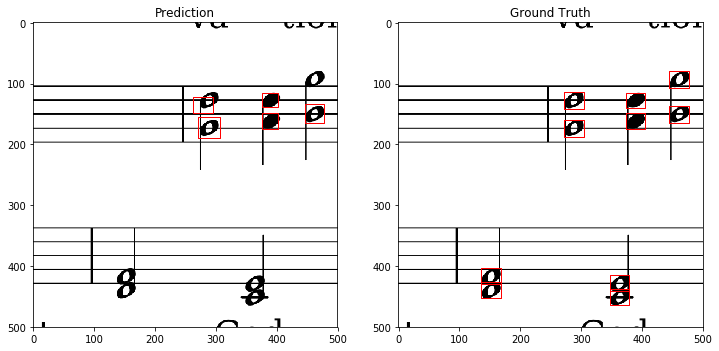

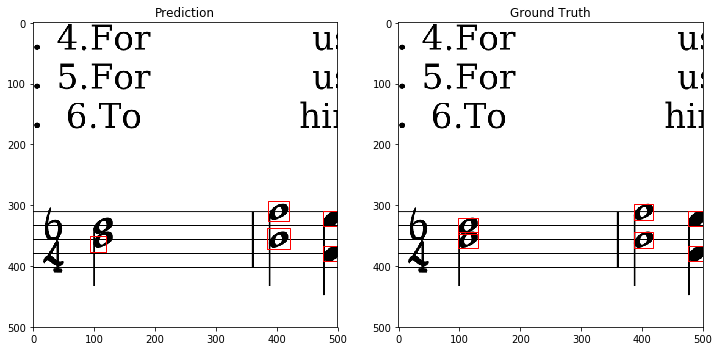

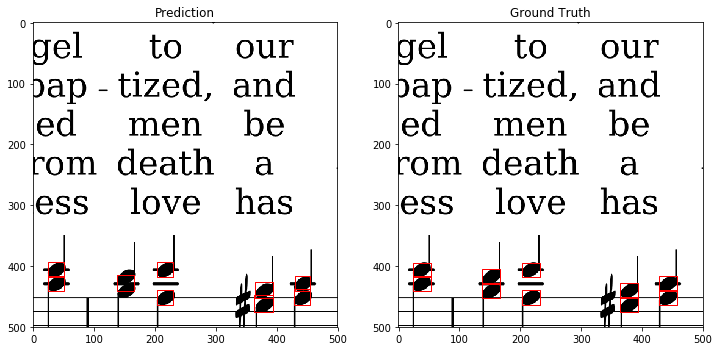

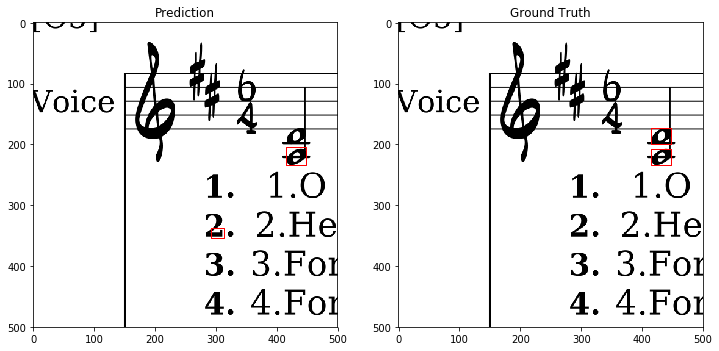

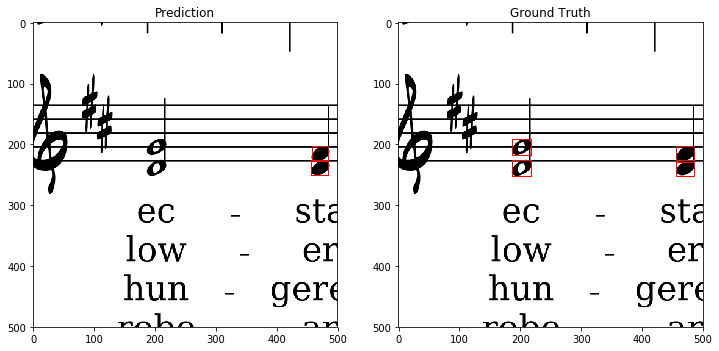

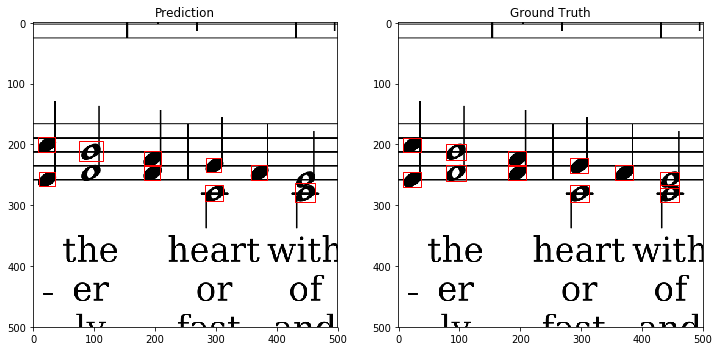

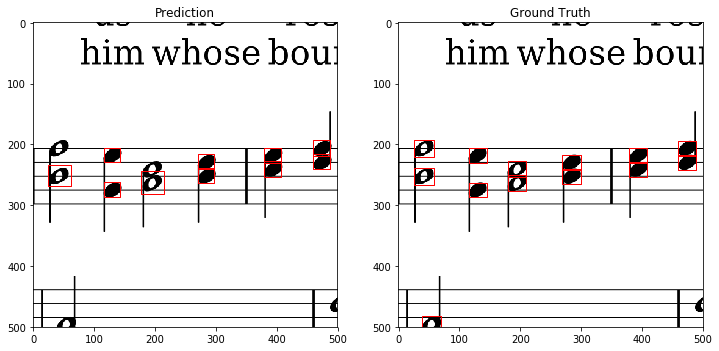

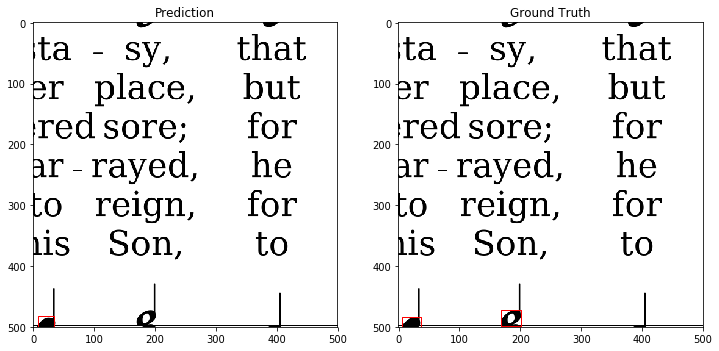

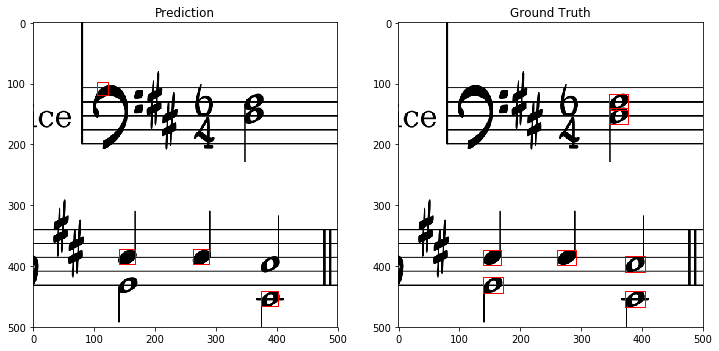

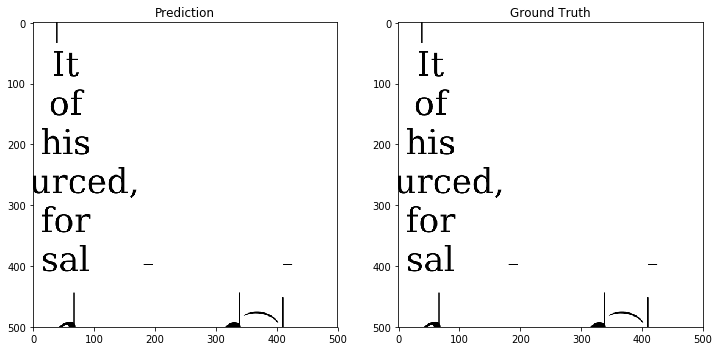

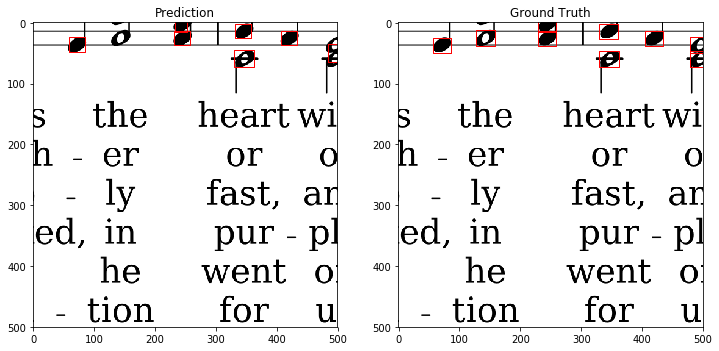

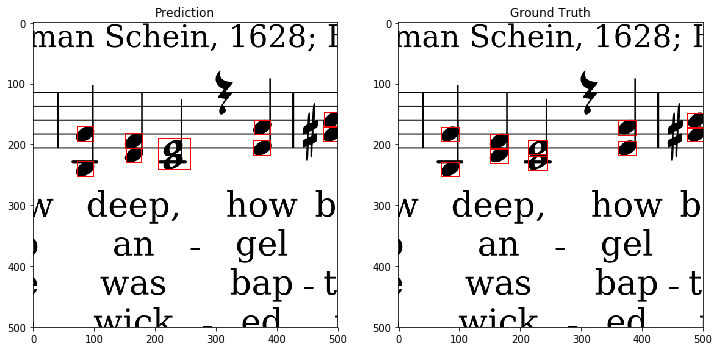

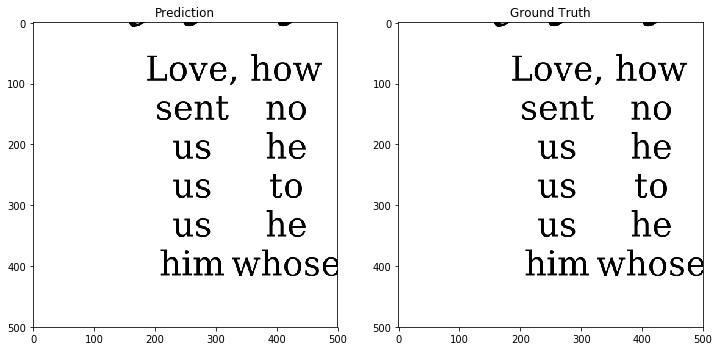

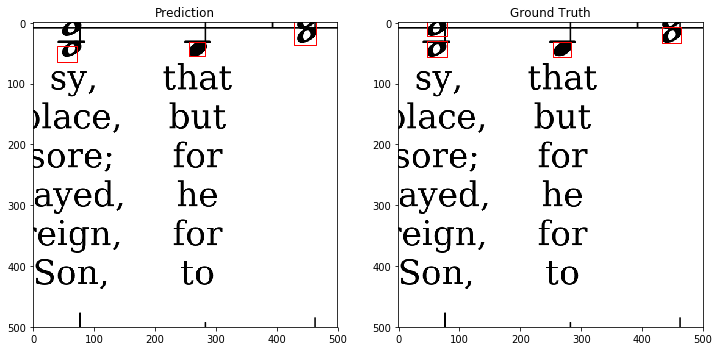

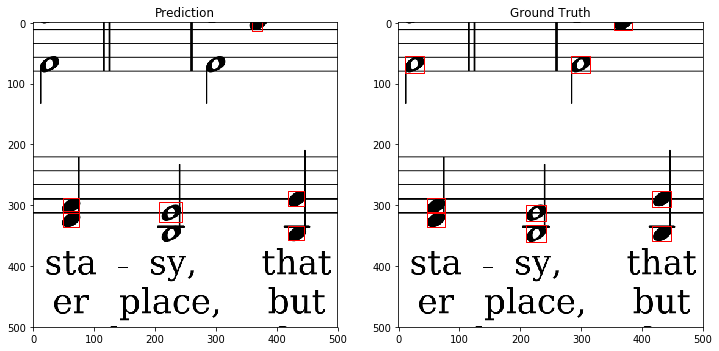

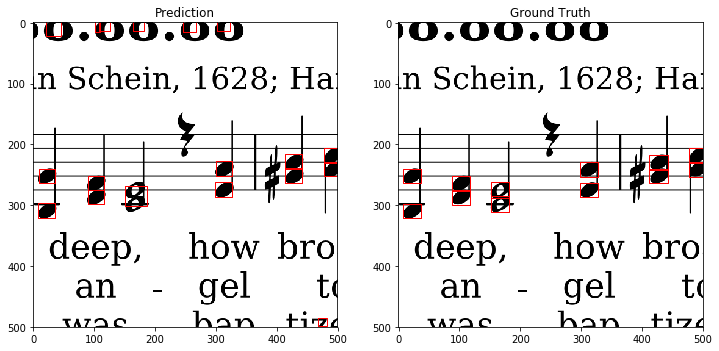

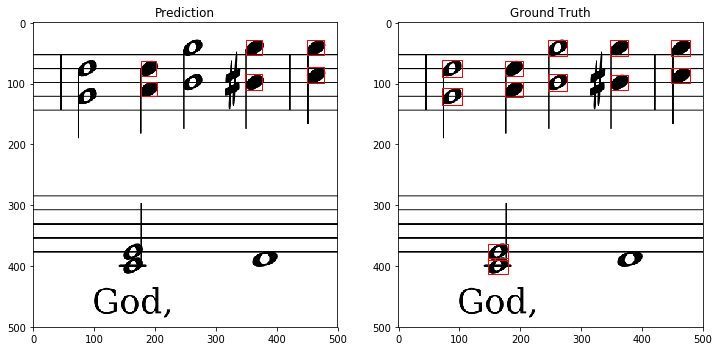

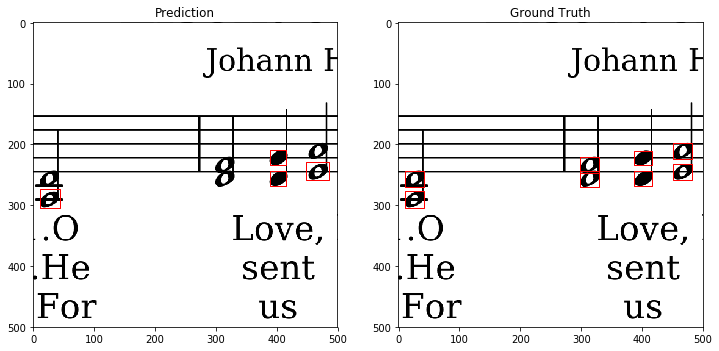

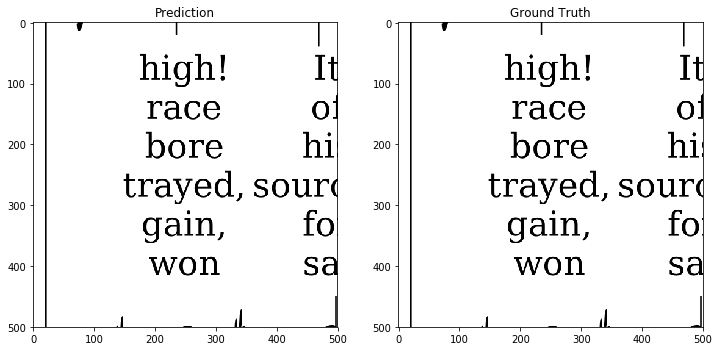

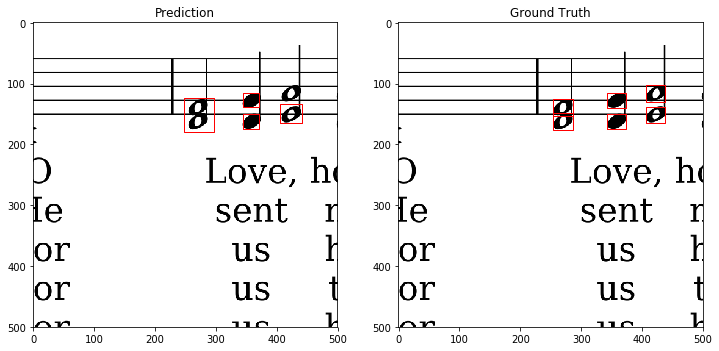

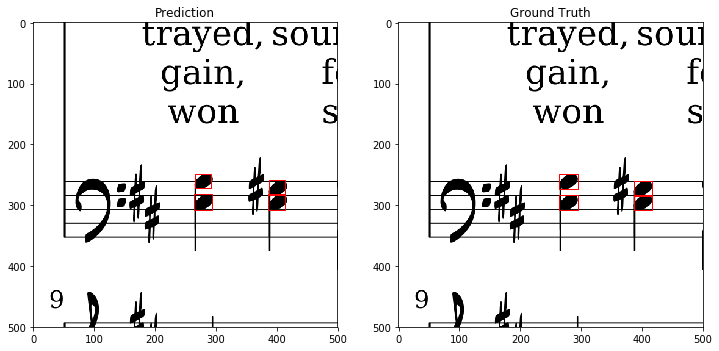

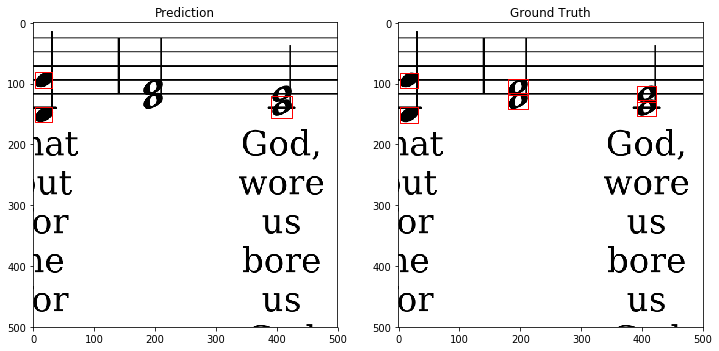

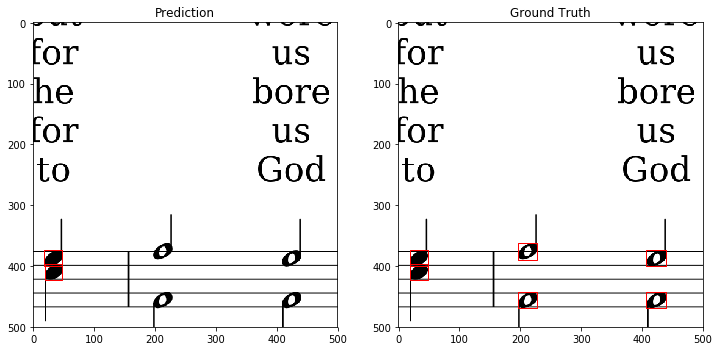

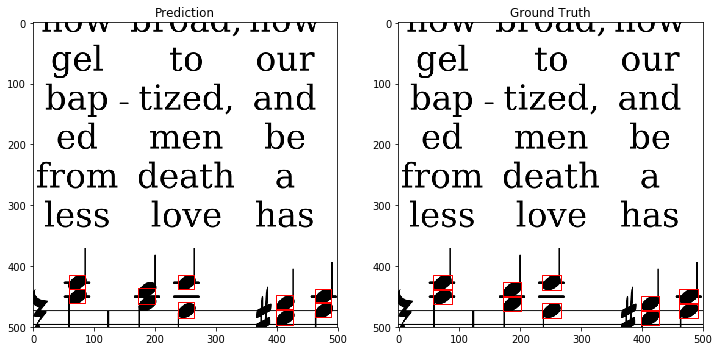

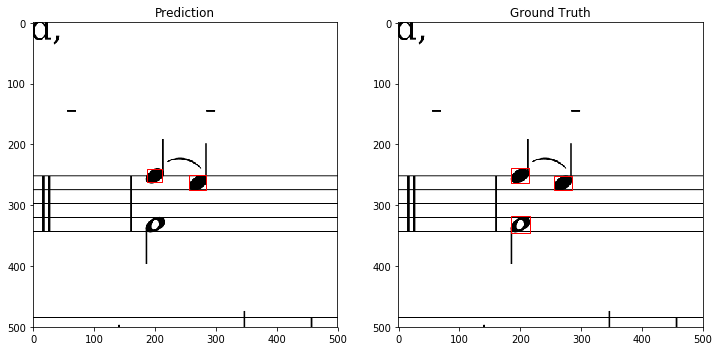

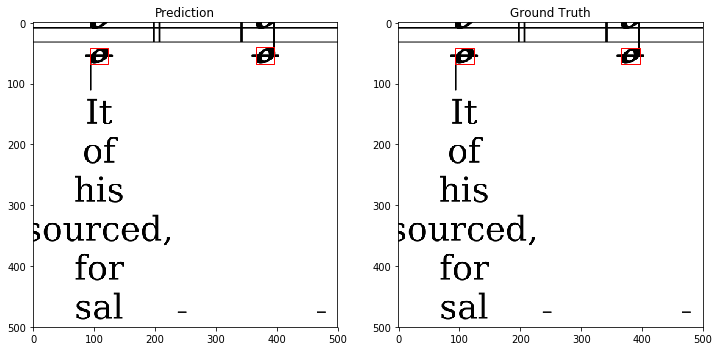

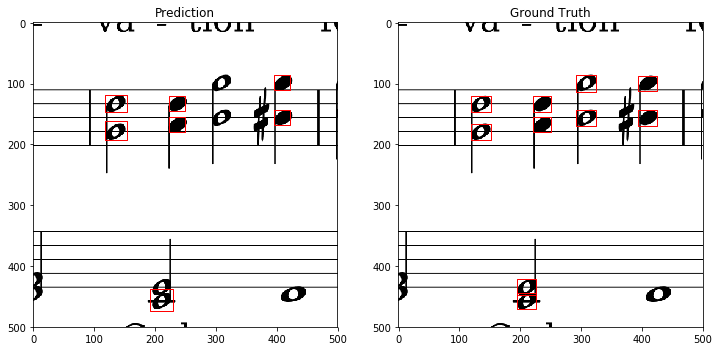

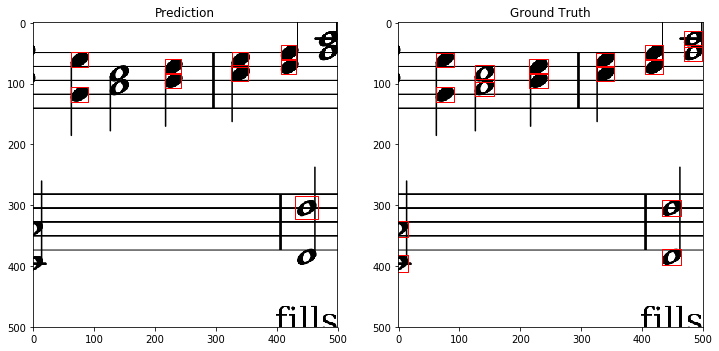

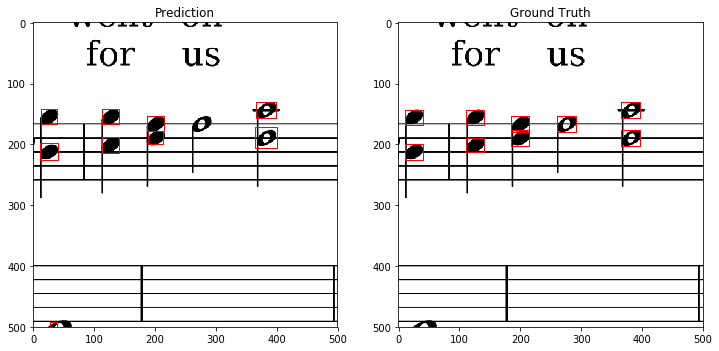

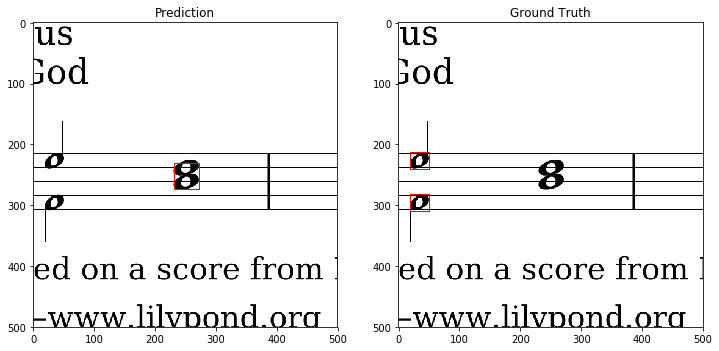

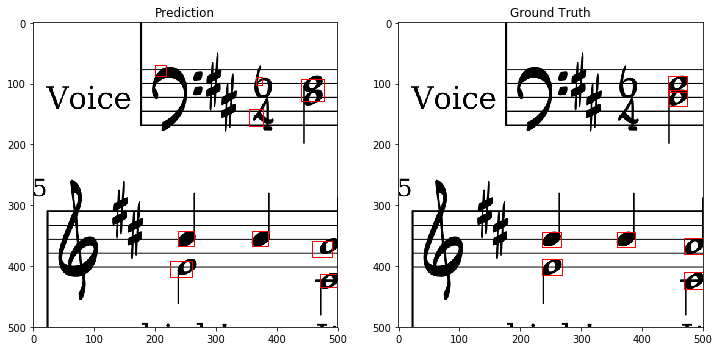

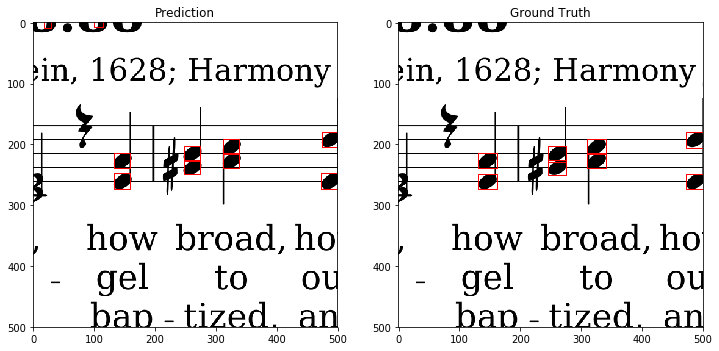

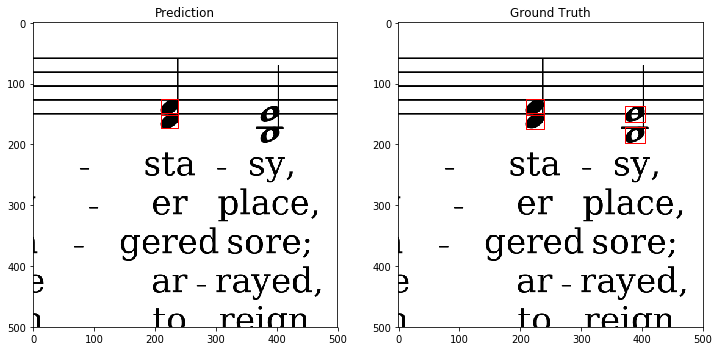

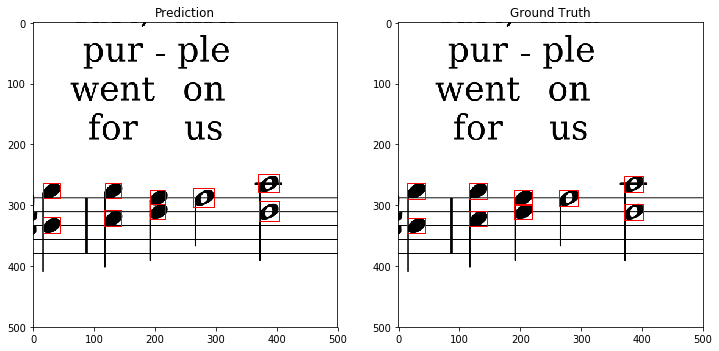

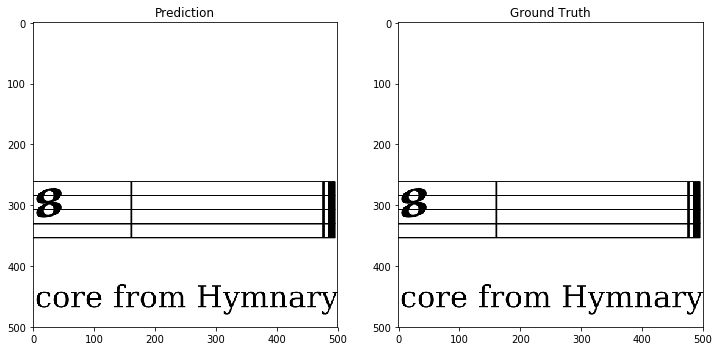

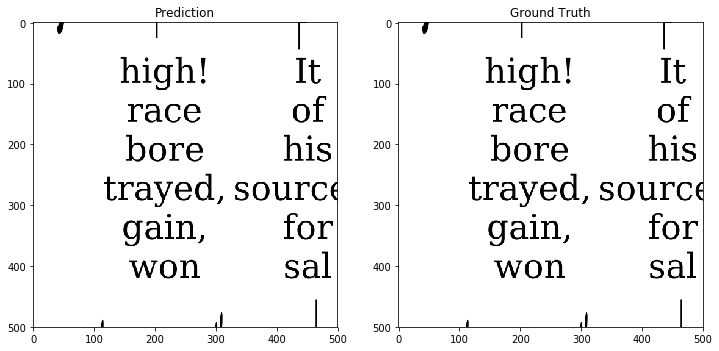

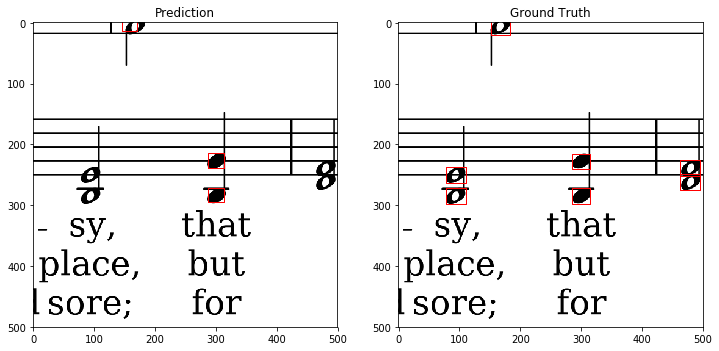

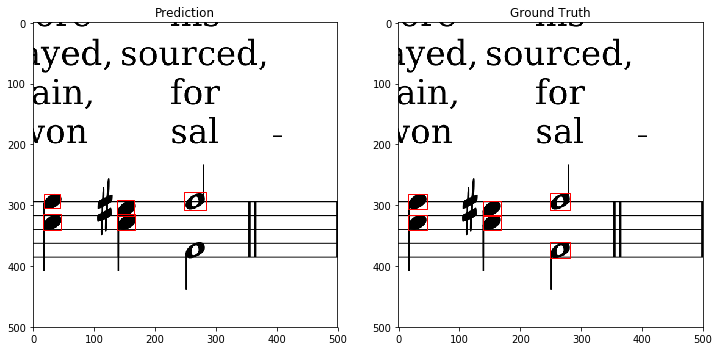

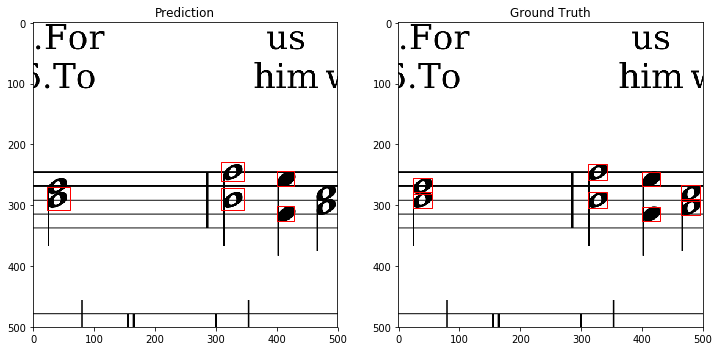

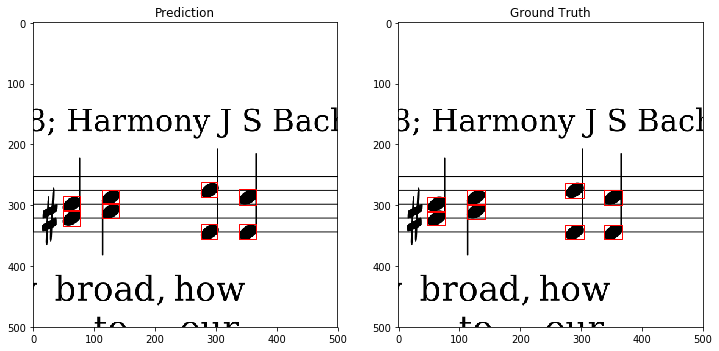

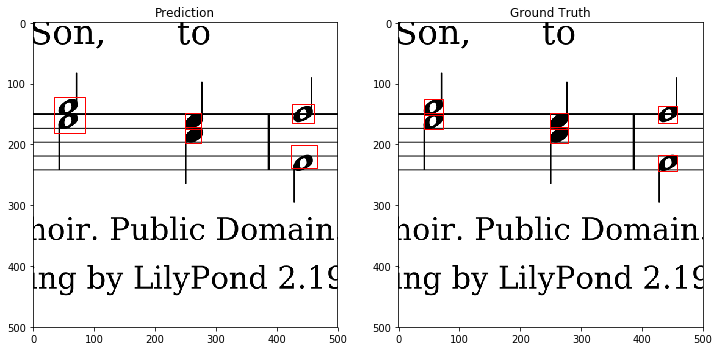

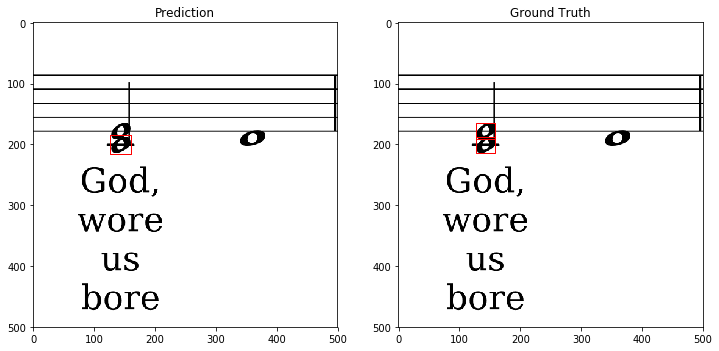

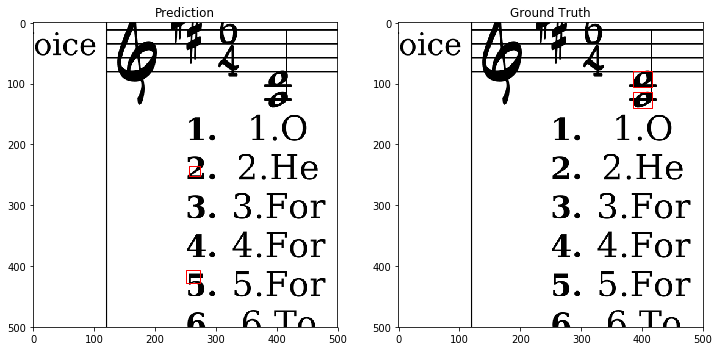

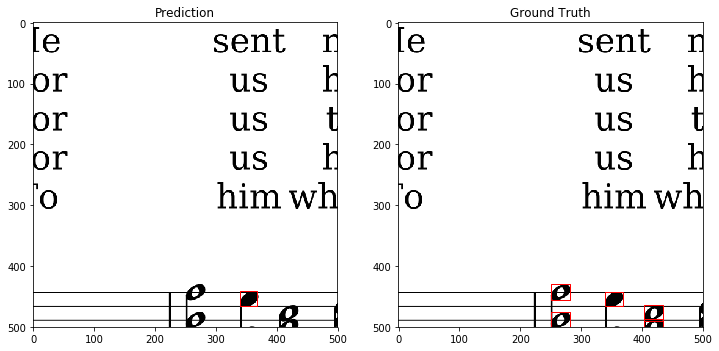

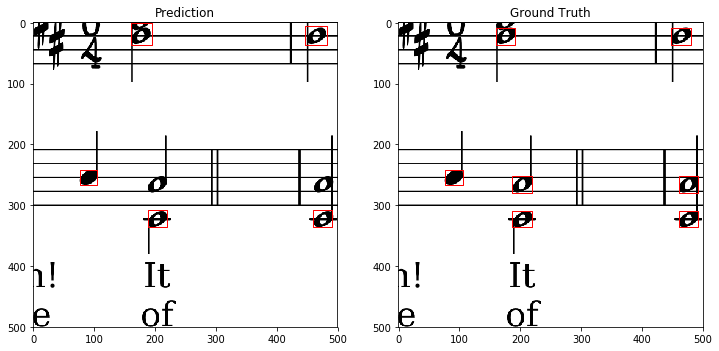

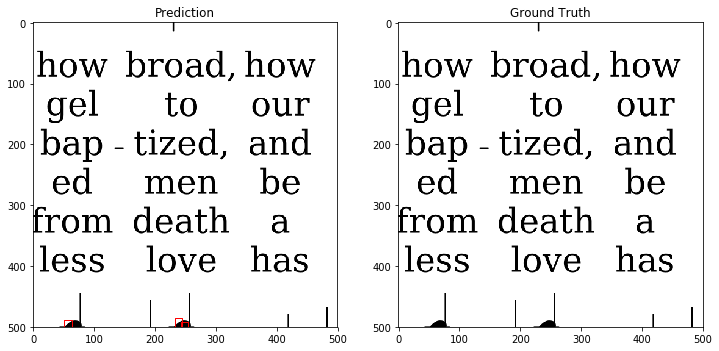

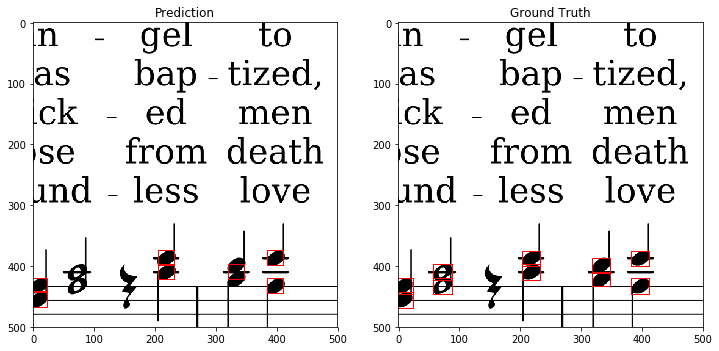

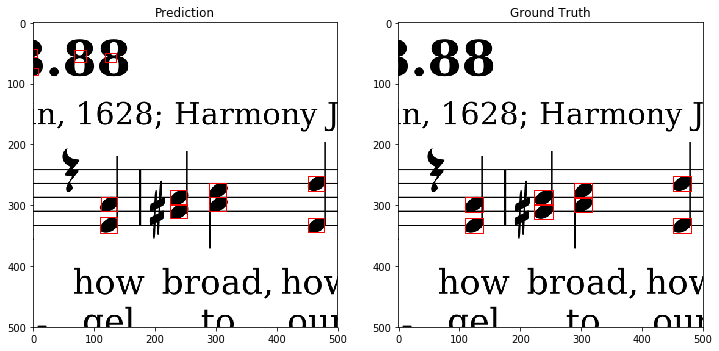

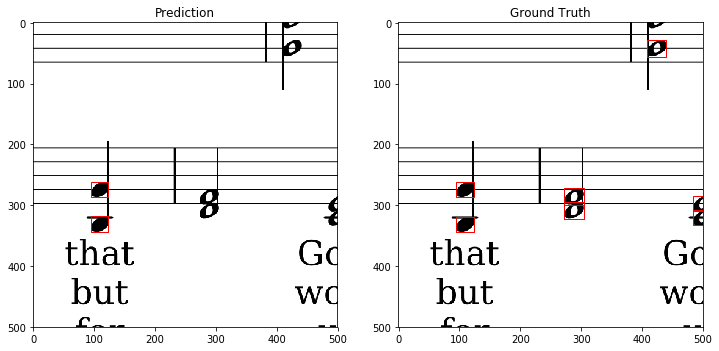

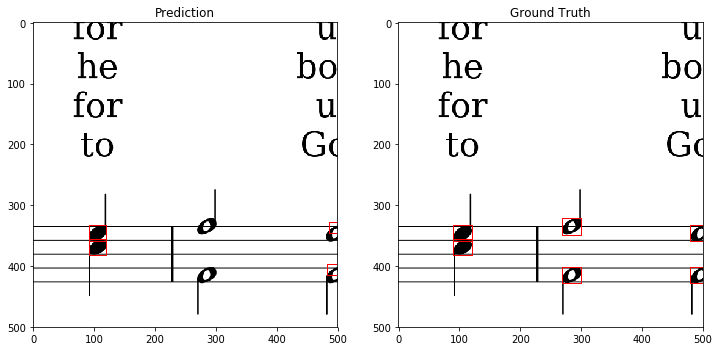

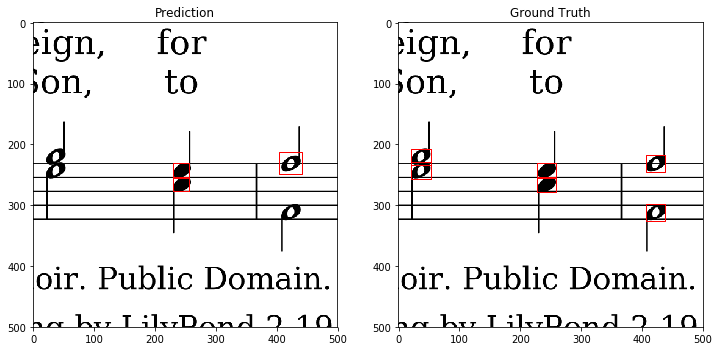

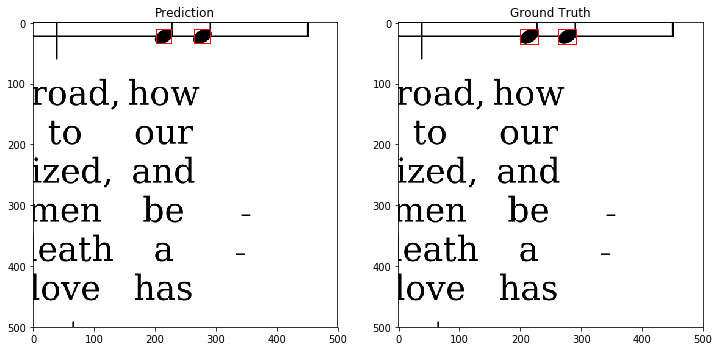

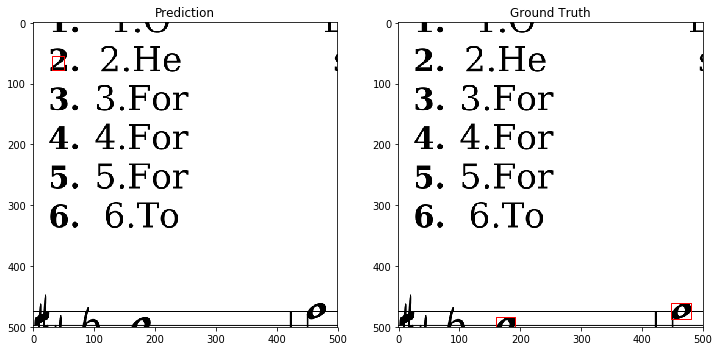

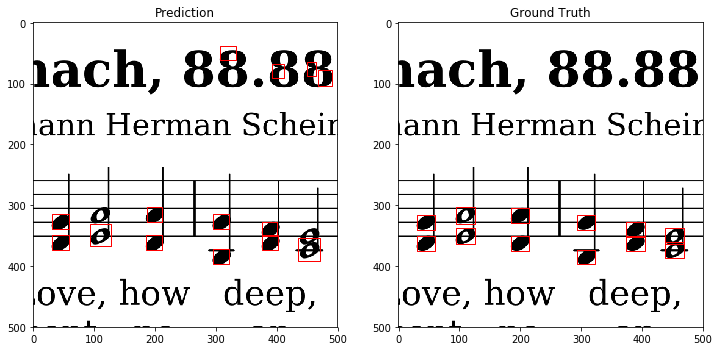

In [196]:
gt_boxes = {}
pred_boxes = {}

for i in range(100):
    X, y = validation_generator[0]
    y_pred = dwd_model.predict(X)
    
    energy_map = np.argmax(y_pred[0], axis=-1)[0]
    energy_map_binarized = 255 * (np.argmax(y_pred[0], axis=-1)[0] < 3) # binarize image
    
    class_prediction_img = np.argmax(y_pred[1], axis=-1)[0]
    bbox_prediction      = y_pred[2][0,:,:,:]
    
    prep = energy_map_binarized
    labels, out_img = find_connected_comp(prep)
    
    n_components = len(np.unique(out_img))
    
    counter = {}
    summation = {}
    center = {}
    class_pred = {}
    bbox = {}
    for label in labels:
        component_id = labels[label]
        if component_id not in counter:
            counter[component_id] = 0
            center[component_id] = (0,0)
            class_pred[component_id] = []
            bbox[component_id] = (0,0)

        counter[component_id] += 1
        center[component_id] = (center[component_id][0] + label[0], center[component_id][1] + label[1])
        class_pred[component_id].append(class_prediction_img[label[0],label[1]])
        bbox[component_id] = (bbox[component_id][0] + bbox_prediction[label[0],label[1],0], bbox[component_id][1] + bbox_prediction[label[0],label[1],1] )

    for center_id in center:
        center[center_id] = (center[center_id][0] / counter[center_id], center[center_id][1] / counter[center_id])
        class_pred[center_id] = max(set(class_pred[center_id]), key = class_pred[center_id].count)
        bbox[center_id] = (bbox[center_id][0] / counter[center_id], bbox[center_id][1] / counter[center_id])
        
    # filter prediction boxes
    boxes = []
    for idx, obj in enumerate(center.keys()):
        boxes.append([center[obj][1] - bbox[obj][1] / 2, center[obj][0] - bbox[obj][0] / 2, 
                      center[obj][1] + bbox[obj][1] / 2, center[obj][0] + bbox[obj][0] / 2, class_pred[obj]])

    boxes = filterBoxes(boxes, [29, 31])
    boxes = np.array(boxes)
    suppressed_box = non_max_suppression_fast(boxes, 0.25)
    
    # compute confidence values
    scores = []
    for idx in range(len(suppressed_box)):
        center_point_c = int((suppressed_box[idx][0] + suppressed_box[idx][2]) / 2)
        center_point_r = int((suppressed_box[idx][1] + suppressed_box[idx][3]) / 2)
        scores.append(energy_map[center_point_r, center_point_c] / 10)
        
    # filter ground truth boxes
    y['boxes'][0] = filterBoxes(y['boxes'][0], classToFilter=['noteheadHalf', 'noteheadBlack'])
        
    # plot
    img = X[0,:,:,0]
    fig, ax = plt.subplots(1, 2, figsize=(12,12))
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')

    patches = []
    for box in suppressed_box:
        patches.append(Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1]))

    pc = PatchCollection(patches, facecolor='None', edgecolor='r')
    ax[0].add_collection(pc)

    patches = []
    for box in y['boxes'][0]:
        patches.append(Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1]))

    pc = PatchCollection(patches, facecolor='None', edgecolor='r')
    ax[1].add_collection(pc)

    ax[0].set_title('Prediction')
    ax[1].set_title('Ground Truth')

    plt.show()
    
    
    # add to dictionary
    gt_boxes[i] = y['boxes'][0]
    
    pred_boxes[i] = {
        'boxes': suppressed_box,
        'scores': scores,
    }

In [197]:
print("mAP = ", evaluate(gt_boxes, pred_boxes))

mAP =  0.41149956211824845


In [198]:
# plt.figure(figsize=(20,20))
# plt.subplot(1,3,1)
# plt.imshow(np.argmax(y_pred[0], axis=-1)[0])
# plt.subplot(1,3,2)
# plt.imshow(np.argmax(y_pred[1], axis=-1)[0])
# plt.subplot(1,3,3)
# plt.imshow(y_pred[2][0,:,:,0])

In [199]:
# plt.imshow(X[0,:,:,0])

In [200]:
# plt.imshow(energy_map_binarized)

In [201]:
# import importlib
# import sheet_id.utils.eval_utils
# importlib.reload(sheet_id.utils.eval_utils)